# Integrations, Plugins, and Model Evaluation

In this notebook, we will explore **FiftyOne's integration capabilities**, **plugin system**, and **model evaluation tools**.
This is particularly useful when working with external frameworks, custom plugins, and evaluating AI models.

![integrations](https://cdn.voxel51.com/getting_started_manufacturing/notebook5/integrations.webp)

## Learning Objectives:
- Understand how FiftyOne integrates with external tools.
- Learn about FiftyOne’s plugin system and how to configure it.
- Use the **voxel51/evaluation** plugin to evaluate models.

---


## FiftyOne Integrations and Plugins

FiftyOne provides a flexible architecture that enables **seamless integration** with external libraries, models, and cloud services.
This is achieved through **integrations** and **plugins** that extend FiftyOne’s core functionalities.

| Feature      | Description |
|-------------|-------------|
| **Integrations** | Connects FiftyOne with platforms like PyTorch, Ultralytics, CVAT, Lightning Flash, and  Albumentations. |
|  | Enables easy dataset ingestion from sources like Hugging Face and Benchmark datasets |
| **Plugins** | Allow users to **extend FiftyOne’s functionality**. |
|  | Can be used for custom dataset visualizations, model evaluations, and interactive tools. |


🔗 **Relevant Documentation:**  
- [FiftyOne Integrations](https://voxel51.com/docs/fiftyone/integrations/index.html)  
- [FiftyOne Plugins](https://voxel51.com/docs/fiftyone/plugins/index.html)


In [ ]:
!pip install fiftyone huggingface_hub gdown umap-learn torch torchvision scikit-learn python-dotenv anomalib open-clip-torch

## Load the MVTec Dataset as usual

In [ ]:
import torch

def get_device():
    """Get the appropriate device for model inference."""
    if torch.cuda.is_available():
        return "cuda"
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    return "cpu"

DEVICE = get_device()

print(f"Using device: {DEVICE}")

Using device: cuda


# Download dataset from source

We can download the file from Google Drive using `gdown`

Let's get started by importing the FiftyOne library, and the utils we need for a COCO format dataset, depending of the dataset format you should change that option. [Supported Formats](https://docs.voxel51.com/user_guide/dataset_creation/datasets.html#supported-formats)


In [ ]:
import gdown

# # Download the coffee dataset from Google Drive

# url = "https://drive.google.com/uc?id=1nAuFIyl2kM-TQXduSJ9Fe_ZEIVog4tth" # original
# gdown.download(url, output="mvtec_ad.zip", quiet=False)

# !unzip mvtec_ad.zip

url = "https://drive.google.com/uc?id=13v04fVX_rNdWR9Gvyc9zZfuWIR0B1XWl" # model-example
gdown.download(url, output="model.ckpt", quiet=False)

!unzip mvtec_ad.zip

import fiftyone as fo # base library and app
#import fiftyone.utils.huggingface as fouh # Hugging Face integration

# Define the new dataset name
dataset_name = "MVTec_AD_EVAL"

# Check if the dataset exists
if dataset_name in fo.list_datasets():
    print(f"Dataset '{dataset_name}' exists. Loading...")
    dataset = fo.load_dataset(dataset_name)
else:
    print(f"Dataset '{dataset_name}' does not exist. Creating a new one...")
    # Clone the dataset with a new name and make it persistent
    #dataset_ = fouh.load_from_hub("Voxel51/mvtec-ad", persistent=True, overwrite=True)
    dataset_ = fo.Dataset.from_dir(
        dataset_dir="/content/mvtec-ad",
        dataset_type=fo.types.FiftyOneDataset
    )
    dataset = dataset_.clone("MVTec_AD")

## Set up the dataset into Anomalib (custom folder) and train the model

I want to clarify that Anomalib natively supports MVTec and you can use Datamodule callback for using MVTec AD dataset. However for the education purposes of this workshop we will manage MVTec Bottle subset as a custom folder in Anomalib. Selecting `OBJECT=bottle` in the next cell and adding normal and abnormal folders to the tree directory.

In [ ]:
# import os
# from anomalib import TaskType
# from pathlib import Path
# from torchvision.transforms.v2 import Resize
# import fiftyone as fo # base library and app
# import fiftyone.utils.huggingface as fouh # Hugging Face integration
# from fiftyone import ViewField as F # helper for defining views
# from anomalib.data import Folder



# dataset = fouh.load_from_hub("Voxel51/mvtec-ad", persistent=True, overwrite=True)
# #dataset = fo.load_dataset("Voxel51/mvtec-ad") # Use this CLI if you already have the dataset
#                                                # in your disk or if this is not the first time you run this notebook

# # Try this for already loaded dataset
# # dataset = fo.load_dataset('mvtec-ad-staging')
# OBJECTS_LIST = [
#     'pill',
#     'zipper',
#     'tile',
#     'bottle',
#     'transistor',
#     'wood',
#     'cable',
#     'capsule',
#     'carpet',
#     'grid',
#     'hazelnut',
#     'leather',
#     'metal_nut',
#     'screw',
#     'toothbrush'
# ]
# OBJECT = "bottle" ## object to train on

# ROOT_DIR = Path("/tmp/mvtec_ad") ## root directory to store data for anomalib
# TASK = TaskType.SEGMENTATION ## task type for the model
# IMAGE_SIZE = (256, 256) ## preprocess image size for uniformity

# # training and inference:
# # step-1 create data loader

# def create_datamodule(object_type, transform=None):
#     ## Build transform
#     if transform is None:
#         transform = Resize(IMAGE_SIZE, antialias=True)
#     normal_data = dataset.match(F("category.label") == object_type).match(
#         F("split") == "train"
#     )
#     abnormal_data = (
#         dataset.match(F("category.label") == object_type)
#         .match(F("split") == "test")
#         .match(F("defect.label") != "good")
#     )
#     normal_dir = ROOT_DIR / object_type / "normal"
#     abnormal_dir = ROOT_DIR / object_type / "abnormal"
#     mask_dir = ROOT_DIR / object_type / "mask"
#     # create directories if they do not exist
#     os.makedirs(normal_dir, exist_ok=True)
#     os.makedirs(abnormal_dir, exist_ok=True)
#     os.makedirs(mask_dir, exist_ok=True)
#     if os.path.exists(str(normal_dir)):
#         normal_data.export(
#             export_dir=str(normal_dir),
#             dataset_type=fo.types.ImageDirectory,
#             export_media="symlink",
#         )
#     for sample in abnormal_data.iter_samples():
#         base_filename = sample.filename
#         dir_name = os.path.dirname(sample.filepath).split("/")[-1]
#         new_filename = f"{dir_name}_{base_filename}"
#         if not os.path.exists(str(abnormal_dir / new_filename)):
#             os.symlink(sample.filepath, str(abnormal_dir / new_filename))
#         if not os.path.exists(str(mask_dir / new_filename)):
#             os.symlink(sample.defect_mask.mask_path, str(mask_dir / new_filename))
#     datamodule = Folder(
#         name=object_type,
#         root=ROOT_DIR,
#         normal_dir=normal_dir,
#         abnormal_dir=abnormal_dir,
#         mask_dir=mask_dir,
#     )
#     datamodule.setup()
#     return datamodule


In [ ]:
# from anomalib.engine import Engine

# # train and save model to disk
# def train_and_export_model(object_type, model, transform=None):
#     engine = Engine()
#     datamodule = create_datamodule(object_type, transform=transform)
#     engine.train(model=model, datamodule=datamodule)

#     return engine

In [ ]:
# from anomalib.models import Padim, Patchcore

# # Load and train padim
# model = Padim()
# engine = train_and_export_model(OBJECT, model)

## Model Evaluation in FiftyOne for anomaly detection in a bottle factory

FiftyOne provides a built-in model evaluation system that supports various evaluation types, such as:
- **Classification Evaluation** (Accuracy, Precision, Recall, F1-score)
- **Object Detection Evaluation** (IoU, mAP)
- **Segmentation Evaluation**

We will use the [**voxel51/evaluation plugin**](https://github.com/voxel51/fiftyone-plugins/blob/main/plugins/evaluation/README.md) to evaluate our model’s performance.

### Steps:
1. Load a dataset with ground truth labels and predictions.
2. Select an evaluation method.
3. Run the evaluation and analyze the results.

**Relevant Documentation:** [Evaluating Models in FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html)


## Load the data into FiftyOne

In [3]:
import fiftyone as fo # base library and app
from fiftyone import ViewField as F # helper for defining views
import fiftyone.utils.huggingface as fouh # Hugging Face integration

# Load the dataset
#dataset_ = fouh.load_from_hub("Voxel51/mvtec-ad", persistent=True, overwrite=True)
#dataset = fo.load_dataset("Voxel51/mvtec-ad") # Use this CLI if you already have the dataset
                                               # in your disk or if this is not the first time you run this notebook

# Define the new dataset name
dataset_name = "MVTec_AD_EVAL"

# Check if the dataset exists
if dataset_name in fo.list_datasets():
    print(f"Dataset '{dataset_name}' exists. Loading...")
    dataset = fo.load_dataset(dataset_name)
else:
    print(f"Dataset '{dataset_name}' does not exist. Creating a new one...")
    # Clone the dataset with a new name and make it persistent
    dataset = dataset_.clone(dataset_name, persistent=True)

# Define the new dataset name for split set
dataset_name_split = "mvtec-bottle_2"

if dataset_name_split in fo.list_datasets():
    print(f"Dataset '{dataset_name_split}' exists. Loading...")
    dataset = fo.load_dataset(dataset_name_split)
else:
    print(f"Dataset '{dataset_name_split}' does not exist. Creating a new one...")
    ## get the test split of the dataset
    test_split = dataset.match(F("category.label") == 'bottle')

    # Clone the dataset into a new one called "mvtec_bottle"
    dataset = test_split.clone("mvtec-bottle_2", persistent=True)


Dataset 'MVTec_AD_EVAL' does not exist. Creating a new one...
Dataset 'mvtec-bottle_2' does not exist. Creating a new one...


In [4]:
print(dataset)

Name:        mvtec-bottle_2
Media type:  image
Num samples: 292
Persistent:  True
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    category:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    defect:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    split:            fiftyone.core.fields.StringField
    defect_mask:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)


In [5]:
print(dataset.last())

<Sample: {
    'id': '6621d76a324f6e05d5838da1',
    'media_type': 'image',
    'filepath': '/content/mvtec-ad/data/data_50/018-57.png',
    'tags': [],
    'metadata': None,
    'created_at': datetime.datetime(2025, 9, 29, 18, 5, 15, 886000),
    'last_modified_at': datetime.datetime(2025, 9, 29, 18, 5, 15, 886000),
    'category': <Classification: {
        'id': '6621d769324f6e05d5837726',
        'tags': [],
        'label': 'bottle',
        'confidence': None,
        'logits': None,
    }>,
    'defect': <Classification: {
        'id': '6621d769324f6e05d5837727',
        'tags': [],
        'label': 'contamination',
        'confidence': None,
        'logits': None,
    }>,
    'split': 'test',
    'defect_mask': <Segmentation: {
        'id': '6621d769324f6e05d5837728',
        'tags': [],
        'mask': None,
        'mask_path': '/content/mvtec-ad/fields/defect_mask/defect_mask_12/018_mask-30.png',
    }>,
}>


## Check if there are previous evaluations

In [6]:
print(dataset.list_evaluations())
#dataset.delete_evaluation('padim_eval')
#if "eval_key" in dataset.get_field_schema():
#    dataset.delete_sample_field("eval_key")

#if "padim_eval"in dataset.get_field_schema():
#    dataset.delete_sample_field("padim_eval")

[]


## Running Inference with Anomalib's Engine

This code demonstrates how to set up and run inference using Anomalib's `Engine` with a **PaDiM** model.


In [ ]:
from anomalib.engine import Engine
from anomalib.models import Padim

#Set up my model with Anomalib

engine = Engine(accelerator="cpu")
model = Padim()

# Specify the path to your trained model checkpoint
ckpt_path_model = "/content/model.ckpt"

# Specify the path to the image you want to run inference on
image_path = "/content/mvtec-ad/data/data_0/000.png"

# Run inference on the specified image
predictions = engine.predict(model=model, data_path=image_path, ckpt_path=ckpt_path_model)

## Visualizing Anomaly Predictions in Anomalib

This code processes and visualizes the anomaly detection results from Anomalib. It extracts prediction details, displays anomaly maps, and overlays them on the input image.


Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: torch.Size([1, 256, 256]), 
Prediction Score: tensor([[1.]]), 
Predicted Mask Shape: torch.Size([1, 256, 256])
tensor([1.]) tensor(True)
1.0


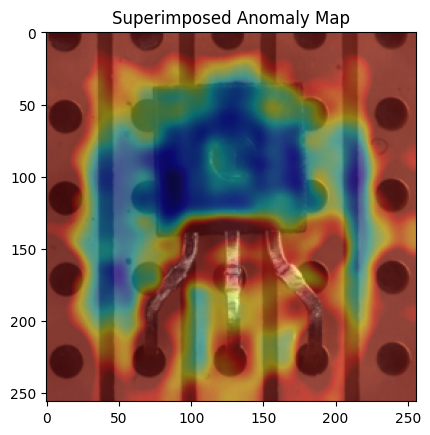

In [8]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from anomalib.utils.post_processing import superimpose_anomaly_map

# Extract the first prediction result
prediction = predictions[0]

# Print key prediction details
print(
    f"Image Shape: {prediction.image.shape},\n"
    f"Anomaly Map Shape: {prediction.anomaly_map.shape}, \n"
    f"Prediction Score: {prediction.pred_score}, \n"
    f"Predicted Mask Shape: {prediction.pred_mask.shape}",
)

# Extract anomaly score and label
pred_score = prediction.pred_score[0]
pred_labels = prediction.pred_label[0]
print(pred_score, pred_labels)

# Load and resize the input image
image_path = prediction.image_path[0]
image_size = prediction.image.shape[-2:]
image = np.array(Image.open(image_path).resize(image_size))

# Extract the predicted anomaly mask
pred_masks = prediction.pred_mask[0].squeeze().cpu().numpy()
plt.imshow(pred_masks)
plt.title("Predicted Anomaly Mask")

# Extract and display the anomaly map
pred_anomaly_map = prediction.anomaly_map[0].squeeze().cpu().numpy()
plt.imshow(pred_anomaly_map)
plt.title("Anomaly Map")

# Superimpose anomaly map on the input image for visualization
heat_map = superimpose_anomaly_map(anomaly_map=pred_anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)
plt.title("Superimposed Anomaly Map")

score_value = prediction.pred_score[0, 0].item()
print(score_value)

## Running Anomaly Detection Inference and Grouping Results in FiftyOne

This function, `run_inference`, performs **anomaly detection** on a collection of images using a pre-trained model in **Anomalib**. The results, including anomaly scores, masks, and heatmaps, are stored in [**FiftyOne's grouped dataset**](https://docs.voxel51.com/user_guide/groups.html?highlight=group) format for better visualization and analysis.


In [9]:
import os
import cv2

def run_inference(sample_collection, key, engine, threshold=0.5, ckpt_path=None):
    # (Optional) if your engine requires a model argument, ensure it is defined or passed in.
    # For this example, we assume your engine has the model already loaded.

    # Directory to save visualization images
    output_dir = "temp_predictions"
    os.makedirs(output_dir, exist_ok=True)

    # Define the new dataset name
    gdataset_name = "anomaly_predictions_grouped"


    # Check if the dataset exists
    if gdataset_name in fo.list_datasets():
        print(f"Dataset '{gdataset_name}' exists. Loading...")
        grouped_dataset = fo.load_dataset(gdataset_name)
        return grouped_dataset

    else:
        print(f"Dataset '{gdataset_name}' does not exist. Creating a new one...")
        # Create a new grouped dataset
        grouped_dataset = fo.Dataset(gdataset_name, overwrite=True, persistent=True)

    grouped_dataset.add_group_field("group", default="original")
    grouped_samples = []  # Will hold all slices (samples) of all groups

    # Iterate over samples in the input collection
    for sample in sample_collection.iter_samples(autosave=True, progress=True):
        # Run inference on the sample's filepath
        predictions = engine.predict(model=engine.model, data_path=sample.filepath, ckpt_path=ckpt_path)
        prediction = predictions[0]

        # --- Process Prediction Outputs ---
        # Extract the prediction score and label
        conf = prediction.pred_score[0, 0].item()
        anomaly = "normal" if conf < threshold else "abnormal"

        # Load original image using the prediction's image path and resize to expected dimensions
        image_path = prediction.image_path[0]
        image_size = prediction.image.shape[-2:]
        image = np.array(Image.open(image_path).resize(image_size))

        # Convert predicted mask and anomaly map to NumPy arrays
        pred_masks = prediction.pred_mask[0].squeeze().cpu().numpy()
        pred_anomaly_map = prediction.anomaly_map[0].squeeze().cpu().numpy()
        # Generate heat map overlay using the provided utility
        heat_map = superimpose_anomaly_map(anomaly_map=pred_anomaly_map, image=image, normalize=True)

        # --- Save Metadata on the Original Sample ---
        sample[f"pred_anomaly_score_{key}"] = conf
        sample[f"pred_anomaly_classification_{key}"] = fo.Classification(label=anomaly)
        sample[f"pred_anomaly_map{key}"] = fo.Heatmap(map=pred_anomaly_map)
        sample[f"pred_heat_map{key}"] = fo.Heatmap(map=heat_map)
        sample[f"pred_anomaly_mask{key}"] = fo.Segmentation(mask=pred_masks)

        sample.save()

        # --- Create a Group for This Prediction ---
        # Use the sample's unique id to build a group id
        group = fo.Group()
        group_id = f"sample_{sample.id}"

        # ----- Original Image Slice -----
        # Ensure image is in uint8 (if not already)
        orig = image.copy()
        if orig.dtype != np.uint8:
            orig = (orig * 255).astype(np.uint8)
        orig_path = os.path.join(output_dir, f"{group_id}_original.png")
        # OpenCV expects BGR, so convert RGB to BGR
        cv2.imwrite(orig_path, cv2.cvtColor(orig, cv2.COLOR_RGB2BGR))
        sample_orig = fo.Sample(filepath=orig_path, group=group.element("original"))
        sample_orig["pred_score"] = conf
        sample_orig["pred_label"] = anomaly
        # --- Save Metadata on the Original Sample ---
        sample_orig[f"pred_anomaly_score_{key}"] = conf
        sample_orig[f"pred_anomaly_classification_{key}"] = fo.Classification(label=anomaly)
        sample_orig[f"pred_anomaly_map{key}"] = fo.Heatmap(map=pred_anomaly_map)
        sample_orig[f"pred_heat_map{key}"] = fo.Heatmap(map=heat_map)
        sample_orig[f"pred_anomaly_mask{key}"] = fo.Segmentation(mask=pred_masks)

        sample.save()

        # ----- Heat Map Slice -----
        heat = heat_map.copy()
        if heat.dtype != np.uint8:
            heat = (heat * 255).astype(np.uint8)
        heat_path = os.path.join(output_dir, f"{group_id}_heat.png")
        cv2.imwrite(heat_path, heat)
        sample_heat = fo.Sample(filepath=heat_path, group=group.element("heat_map"))

        # ----- Predicted Mask Slice -----
        mask = pred_masks.copy()
        if mask.dtype != np.uint8:
            mask = (mask * 255).astype(np.uint8)
        mask_path = os.path.join(output_dir, f"{group_id}_mask.png")
        cv2.imwrite(mask_path, mask)
        sample_mask = fo.Sample(filepath=mask_path, group=group.element("pred_mask"))

        # ----- Anomaly Map Slice -----
        anom = pred_anomaly_map.copy()
        if anom.dtype != np.uint8:
            anom = (anom * 255).astype(np.uint8)
        anom_path = os.path.join(output_dir, f"{group_id}_anomaly.png")
        cv2.imwrite(anom_path, anom)
        sample_anom = fo.Sample(filepath=anom_path, group=group.element("anomaly_map"))

        # Add all four slices for this prediction to the list
        grouped_samples.extend([sample_orig, sample_heat, sample_mask, sample_anom])

    # Add all grouped samples to the grouped dataset
    grouped_dataset.add_samples(grouped_samples)

    # Optionally launch the FiftyOne App to inspect the grouped dataset

    return grouped_dataset

### **Function Overview**
```python
def run_inference(sample_collection, key, engine, threshold=0.5, ckpt_path=None):
```
- **sample_collection**: The input FiftyOne dataset containing images for inference.
- **key**: Identifier for Anomalib model.
- **engine**: The inference engine (e.g., Anomalib's Engine) with the model loaded.
- **threshold**: Score threshold for classifying images as "normal" or "abnormal".
- **ckpt_path:** Path to the trained model's checkpoint.

In [ ]:
grouped_dataset = run_inference(dataset, "padim", engine, threshold=0.5, ckpt_path=ckpt_path_model)


## Reloading and Visualizing the Grouped Dataset in FiftyOne

After running inference, we reload the grouped dataset to ensure all predictions are updated and then visualize the results in the **FiftyOne App**.


In [ ]:
grouped_dataset.reload()
print(grouped_dataset.last())

session = fo.launch_app(grouped_dataset, port=5155, auto=False)
print(session.url)

![grouped_prediction](https://cdn.voxel51.com/getting_started_manufacturing/notebook5/grouped_prediction.webp)

## Evaluating Anomaly Classification with the Model Evaluation Plugin in FiftyOne

When using the **Model Evaluation Plugin** in FiftyOne, we can evaluate model predictions using either:
1. **The Model Evaluation Panel in the FiftyOne App** – Interactive UI-based evaluation.
2. **The FiftyOne SDK** – Programmatic evaluation via Python scripts.

**Which one to use?**  
- If you prefer an **interactive visual analysis**, the **FiftyOne App** provides an intuitive panel for evaluating models.  
- If you need **automated and reproducible results**, the **FiftyOne SDK** allows for batch evaluation and detailed reporting.

   


In [12]:
import numpy as np

for sample in dataset.iter_samples(progress=True):
    # If the sample already has "defect2", skip it
    # if "defect" in sample and sample["defect2"] is not None:
    #     continue

    # Otherwise, create "defect2"
    if sample["defect"].label == "good":
        sample["defect_mask"] = fo.Segmentation(
            mask=np.zeros_like(sample["pred_anomaly_maskpadim"].mask)
        )
        sample["defect2"] = fo.Classification(label="normal")
    else:
        sample["defect2"] = fo.Classification(label="abnormal")

    sample.save()

eval_key = "padim_eval"

# Now evaluate on the "defect2" field
eval_classif_padim = dataset.evaluate_classifications(
    "pred_anomaly_classification_padim",
    gt_field="defect2",
    method="binary", #method is important to see data in the FO app
    classes=["normal", "abnormal"],
    eval_key=eval_key,  # <--- store this run under "padim_eval"
)
eval_classif_padim.print_report()

 100% |█████████████████| 292/292 [14.2s elapsed, 0s remaining, 26.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 292/292 [14.2s elapsed, 0s remaining, 26.0 samples/s]      


              precision    recall  f1-score   support

      normal       0.97      1.00      0.98       229
    abnormal       0.98      0.90      0.94        63

    accuracy                           0.98       292
   macro avg       0.98      0.95      0.96       292
weighted avg       0.98      0.98      0.98       292



In [ ]:
print(dataset)
print(dataset.last())

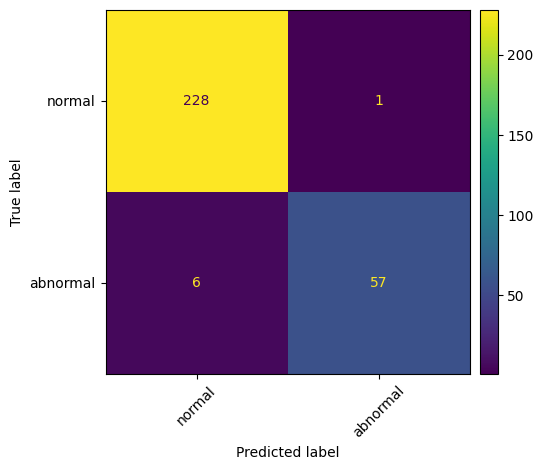

In [14]:
# Plot a confusion matrix
plot = eval_classif_padim.plot_confusion_matrix(backend="matplotlib")
plot.show()

Ignoring unsupported argument `thresholds` for the 'matplotlib' backend


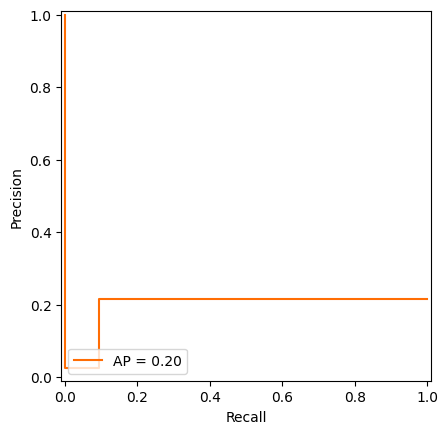

In [15]:
# Plot a PR curve
plot = eval_classif_padim.plot_pr_curve(backend="matplotlib")
plot.show()


## Visualizing Evaluation Results

After running the evaluation, we can inspect the results using the FiftyOne App:

In the App, you can:

Filter samples by correct or incorrect predictions.
View IoU scores, confusion matrices, and detection overlaps.
Generate customized evaluation reports.

Relevant Documentation: [Interactive Model Evaluation in FiftyOne](https://github.com/voxel51/fiftyone-plugins/blob/main/plugins/evaluation/README.md)


In [16]:
session = fo.launch_app(dataset, port=5155, auto=False)
print(session.url)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


https://5155-m-s-1rcmbt4d6vfbf-a.us-east4-1.prod.colab.dev?polling=true


![visualizate_evaluation](https://cdn.voxel51.com/getting_started_manufacturing/notebook5/visualizate_evaluation.webp)



### Next Steps:
Try using other plugins or **create your own** to extend FiftyOne’s capabilities! 🚀
